## Demo: repeating a subcycle until a stop condition is triggered
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is **executed while a stop condition is not yet met**.

For this example we work with the following sub processes:
* sailing empty
* loading
* sailing full
* unloading

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 50
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 50,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.00001,
                 "unloading_rate": 0.00001,
                 "capacity": 4,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes
sub_processes = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=4,
        duration=1000,
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="basic activity",
        registry=registry,
        duration=0,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "opp": "gt", "level":25}],
)

#### 4. Register processes and run simpy

In [8]:
# initate the simpy processes defined in the 'while activity' and run simpy
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [9]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes, sequential_activity])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,sailing empty,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
1,sailing empty,1970-01-01 00:00:00.000000,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
2,loading,1970-01-01 00:00:00.000000,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,loading,1970-01-01 00:16:40.000000,STOP,POINT (4.18055556 52.18664444),4.0,NaN,NaN
4,sailing full,1970-01-01 00:16:40.000000,START,POINT (4.18055556 52.18664444),4.0,NaN,NaN
...,...,...,...,...,...,...,...
65,sailing full,1970-01-01 07:00:56.719687,STOP,POINT (4.25222222 52.11428333),4.0,NaN,NaN
66,unloading,1970-01-01 07:00:56.719687,START,POINT (4.25222222 52.11428333),4.0,NaN,NaN
67,unloading,1970-01-01 07:17:36.719687,STOP,POINT (4.25222222 52.11428333),0.0,NaN,NaN
68,basic activity,1970-01-01 07:17:36.719687,START,POINT (4.25222222 52.11428333),0.0,additional log,efeb8b39-c383-45d9-b544-baffc4bd59f5


##### 5.2 Visualise gantt charts

In [10]:
plot.get_gantt_chart([while_activity, sequential_activity, *sub_processes])

In [11]:
plot.get_gantt_chart([vessel01, from_site, to_site])

##### 5.3 Visualise container volume developments

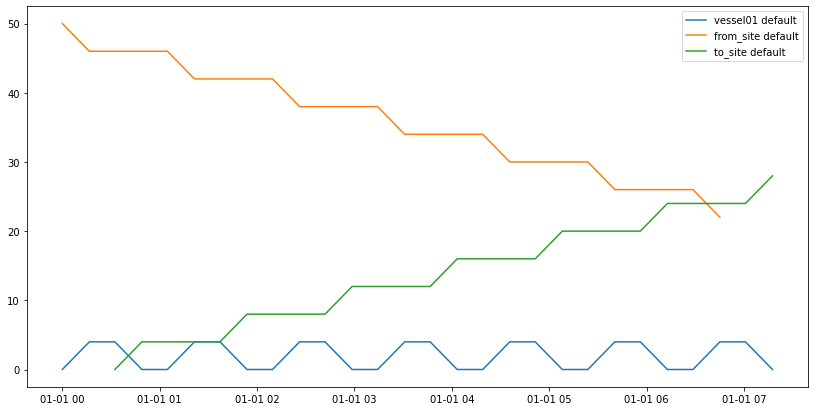

In [12]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

#### Sandbox

In [13]:
pd.DataFrame.from_dict(vessel01.log)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,1970-01-01 00:00:00.000000,788bf5d8-6d13-4996-bb2a-079739ac2381,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
1,1970-01-01 00:00:00.000000,788bf5d8-6d13-4996-bb2a-079739ac2381,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
2,1970-01-01 00:00:00.000000,9b99074d-4998-4c33-9878-65d37c6ff7ed,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
3,1970-01-01 00:16:40.000000,9b99074d-4998-4c33-9878-65d37c6ff7ed,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
4,1970-01-01 00:16:40.000000,27871b3a-9cc9-4478-aa6b-75d115cf628b,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
...,...,...,...,...,...
65,1970-01-01 07:00:56.719687,27871b3a-9cc9-4478-aa6b-75d115cf628b,STOP,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
66,1970-01-01 07:00:56.719687,3ea2f9d1-ae13-4c40-969d-4f7397345449,START,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
67,1970-01-01 07:17:36.719687,3ea2f9d1-ae13-4c40-969d-4f7397345449,STOP,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
68,1970-01-01 07:17:36.719687,efeb8b39-c383-45d9-b544-baffc4bd59f5,START,"{'geometry': POINT (4.25222222 52.11428333), '...","{'type': 'additional log', 'ref': 'efeb8b39-c3..."


In [14]:
list(set(vessel01.log["ActivityID"]))

['efeb8b39-c383-45d9-b544-baffc4bd59f5',
 '3ea2f9d1-ae13-4c40-969d-4f7397345449',
 '788bf5d8-6d13-4996-bb2a-079739ac2381',
 '9b99074d-4998-4c33-9878-65d37c6ff7ed',
 '27871b3a-9cc9-4478-aa6b-75d115cf628b']